In [1]:
import numpy as np
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt

# import sys
# sys.path.insert(0, '../fem')
# from GRF_new import *

In [44]:
class GRF():
    def __init__(self, **kwargs):
        super().__init__()
        self.d = kwargs['d']
        self.l = kwargs['l']
        self.lowerbound = kwargs['lowerbound']
        self.upperbound = kwargs['upperbound']
        self.N_gridpoints = int(1/self.l) + 1
        self.compute_grid()
        self.compute_cov()
        self.compute_GRFpoints()
        self.compute_RBFintcoeffs()
        if self.lowerbound!=None or self.upperbound!=None:
            self.compute_minmax()
        
    def compute_grid(self):
        # if self.d==2:
        #     X, Y = np.mgrid[0:1:self.N_gridpoints*1j, 0:1:self.N_gridpoints*1j]
        #     self.x_grid = np.vstack([X.ravel(), Y.ravel()]).T
        self.x_grid = np.random.uniform(0,1,size=(self.N_gridpoints**self.d, self.d))

        def compute_cov(self):
        self.cov = np.exp(-distance_matrix(self.x_grid, self.x_grid, p=2)**2/(2*self.l**2))
    
    def compute_GRFpoints(self):
        self.f = np.random.multivariate_normal(np.zeros(self.N_gridpoints**self.d), cov=self.cov)
    
    def compute_RBFintcoeffs(self):
        cov_inv = np.linalg.inv(self.cov)
        self.f_hat = np.einsum('ij,j->i', cov_inv, self.f)
    
    def compute_minmax(self):
        if self.d==2:
            X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
            x = np.vstack([X.ravel(), Y.ravel()]).T
        terms = self.f_hat[:,None]*np.exp(-np.sum((x[None,:,:] - self.x_grid[:,None,:])**2, axis=-1)/(2*self.l**2))
        f = np.sum(terms, axis=0)
        if self.lowerbound!=None:
            self.f_min = np.amin(f)
        if self.upperbound!=None:
            self.f_max = np.amax(f)
            
    def RBFint(self):
        def function(x):
            terms = self.f_hat[:,None]*np.exp(-np.sum((x[None,:,:] - self.x_grid[:,None,:])**2, axis=-1)/(2*self.l**2))
            output = np.sum(terms, axis=0)
            return output
        return function

    def RBFint_pointwise(self):
        def function(x):
            terms = self.f_hat*np.exp(-np.sum((x - self.x_grid)**2, axis=-1)/(2*self.l**2))
            output = np.sum(terms)
            return output
        return function
    
    def RBFint_scaled(self):
        def function(x):
            if self.lowerbound==None and self.upperbound==None:
                output_scaled = self.RBFint()(x)
            if self.lowerbound!=None and self.upperbound==None:
                output_scaled = self.RBFint()(x) - self.f_min + self.lowerbound
            if self.lowerbound!=None and self.upperbound!=None:
                output_scaled = (self.RBFint()(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
                output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
            return output_scaled
        return function
            
    def RBFint_pointwise_scaled(self):
        def function(x):
            if self.lowerbound==None and self.upperbound==None:
                output_scaled = self.RBFint_pointwise()(x)
            if self.lowerbound!=None and self.upperbound==None:
                output_scaled = self.RBFint_pointwise()(x) - self.f_min + self.lowerbound
            if self.lowerbound!=None and self.upperbound!=None:
                output_scaled = (self.RBFint_pointwise()(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
                output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
            return output_scaled
        return function

In [143]:
GRFparams = {'d': 2,
             'l': np.random.uniform(),
             'lowerbound': 0,
             'upperbound': 1}
print(GRFparams['l'])

0.016168914237580934


(3844, 2)


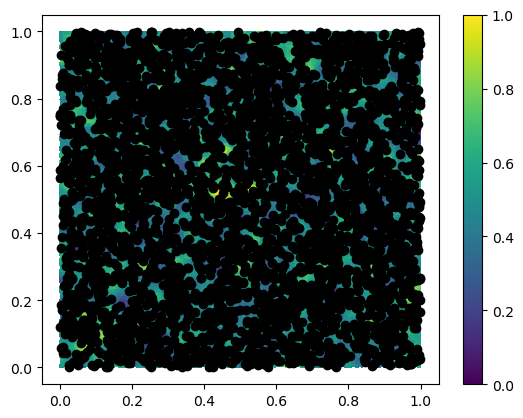

In [144]:
# func = GRF.RBFint()
grf = GRF(**GRFparams)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
grf.RBFint_scaled()(x_i)
plt.tripcolor(x_i[:,0], x_i[:,1], grf.RBFint_scaled()(x_i))
plt.scatter(grf.x_grid[:,0], grf.x_grid[:,1], color='black')
plt.colorbar()

In [115]:
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.array([0.5,0.5])
GRF(**GRFparams).RBFint_pointwise_scaled()(x_i)

(9, 2)


0.6344998436873784

In [6]:
simparams = {'d': 2}
trainingdataparams = {'N_samples': 1000,
                     'N_sensornodes': 72*72}

In [7]:
thetaparams = {'l': np.random.uniform(),
               'lowerbound': 0.02,
               'upperbound': None
               'boundary': None}

fparams = {'l': np.random.uniform(),
           'lowerbound': None,
           'upperbound': None
           'boundary': None}

etaparams = {'l': np.random.uniform(),
             'lowerbound': None,
             'upperbound': None
             'Gamma': }

inputs = {'theta': thetaparams,
               'f': fparams,
               'eta': etaparams}

trainingdataparams['inputs'] = inputs

In [8]:
class GRFset():
    def __init__(self, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.grfs_nutils, self.grfs_NGO, self.grfs_VarMiON = self.functionlists(**self.kwargs)
        
    def functionlists(self):
        
        x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(self.kwargs['N_sensornodes'])*1j, 0:1:np.sqrt(self.kwargs['N_sensornodes'])*1j]
        sensornodes = np.vstack([x_sensor.ravel(), y_sensor.ravel()]).T
        
        grfs_NGO = []
        grfs_nutils = []
        grfs_VarMiON = np.zeros((self.kwargs['N_samples'],self.kwargs['N_sensornodes'])) 
        
        for i in range(self.kwargs['N_samples']):
            grf = GRF(**self.kwargs)
            grf_NGO = grf.RBFint_scaled()
            grf_nutils = grf.RBFint_pointwise_scaled()
            grfs_NGO.append(grf_NGO)
            grfs_nutils.append(grf_nutils)
            grfs_VarMiON[i] = grf_NGO(sensornodes)
            
        grfs_NGO = np.array(grfs_NGO)
        grfs_nutils = np.array(grfs_nutils)
        
            
        return grfs_nutils, grfs_NGO, grfs_VarMiON

In [10]:
grfset = GRFset(**simparams, **trainingdataparams, **inputs['theta'])